# Lab-1.2: Linear vector regression

Creator: J. Hickman

[Click here to download the notebook for the assignment](lab-1.2.ipynb.zip)

**Overview** 

* In the previous lab and home-work, we confined ourself to the case of "scalar" regression. 
* Meaning that the modeling function received a vector as input $\mathbf x$, but only output one number (i.e a scalar).
   $$ y=M(\mathbf x | \mathbf w)$$
* Where $\mathbf w$ are the model parameters
* In this lab we generalize the lab from last week to the case of general multi-variable vector regression. 
  $$ \mathbf y=M(\mathbf x | \mathbf w)$$
* Meaning that the model takes a vector and returns a vector.
* Your solution should be fully general
  * This means it should work for an arbitrary input matrix
  * And should be able to fit a model with an arbitrary number of fitting parameters

**Instructions** 

* Read and work through all tutorial content and do all exercises below
  
**Submission:**

* You need to upload ONE documents to Canvas when you are done
  * (1) A PDF (or HTML) of the completed form of this notebook 
* The final uploaded version should NOT have any code-errors present 
* All outputs must be visible in the uploaded version, including code-cell outputs, images, graphs, etc

# Part-1: Demonstration

## Import packages 

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from   scipy.optimize import minimize
import pandas as pd
import seaborn as sns

## Data generating function

* For simplicity and clarity, we will use artificial data, that way we know the ground truth data generating function.
  
* **Ground truth**
$$y_0(\mathbf x)=1.1+3.4x_0+1.2x_1-5.6x_2$$
$$y_1(\mathbf x)=-3+2.4x_0-5.2x_1+7.6x_2$$

* We will also inject some noise into the data, to make it more realistic.

* This can be written in a vectorized matrix form as

$$ \mathbf y\mathbf(x)=\mathbf b+\mathbf w \mathbf x$$

* Since we already know the ground truth, we should see that our predicted parameters are close to the ground truth parameters
  
*  So if everything goes well, our model should predict numbers close to the following (depending on the size of the noise).

$$ \mathbf w =\begin{pmatrix}
3.4 & 1.2 & -5.6\\
2.4 & -5.2 & 7.6\\
\end{pmatrix} \,\,\,\,\,\, \mathbf b =\begin{pmatrix}
1.1  \\
-3.0  \\
\end{pmatrix}
$$

* This is a low dimensional case, however, the formalism is general, and can be extended easily to an arbitrary dimension. 


## Generate data

Let's apply the data generating function discussed above to create some toy data.

In [2]:
N=500

# WITH NOISE
noise_magnitude=0.0  
noise=noise_magnitude*np.random.normal(0,1,(N,2));

# NO NOISE

#DEFINE A RANDOM INPUT MATRIX (X) WITH THREE FEATURES
x=np.random.normal(5,2,(N,3)); 
x_train=x

# GENERATE DATA WITH DATA GENERATING FUNCTION
y0=1.1+3.4*x[:,0]+1.2*x[:,1]-5.6*x[:,2]+noise[:,0]; 
y0=y0.reshape(N,1)
y1=-3.0+2.4*x[:,0]-5.2*x[:,1]+7.6*x[:,2]+noise[:,1]
y1=y1.reshape(N,1)
# print(y0.shape,y1.shape)

# COMBINE INTO MATRIX
y=np.concatenate((y0,y1),axis=1); 

# PRINT SHAPES 
print("noise :",noise.shape)
print("x :",x.shape)
print("y :",y.shape)


noise : (500, 2)
x : (500, 3)
y : (500, 2)


**IMPORTANT** 

In this case we **won't** normalize the data, even though we typically would.

The reason for this is;

  * (1) The data is already on a relatively uniform scale (~100 to 100) and should be easy to fit.

  * (2) We want to relate our regression results to the expected parameterization of the data generating function. However, fitting to normalized data  would result in a parameter prediction for the normalize data rather than the original data

## Visualize the data 

Before moving on, let's take a quick look at the data

**What can we tell from this plot? Does it match what we would expect for this generating function** 

(500, 5)


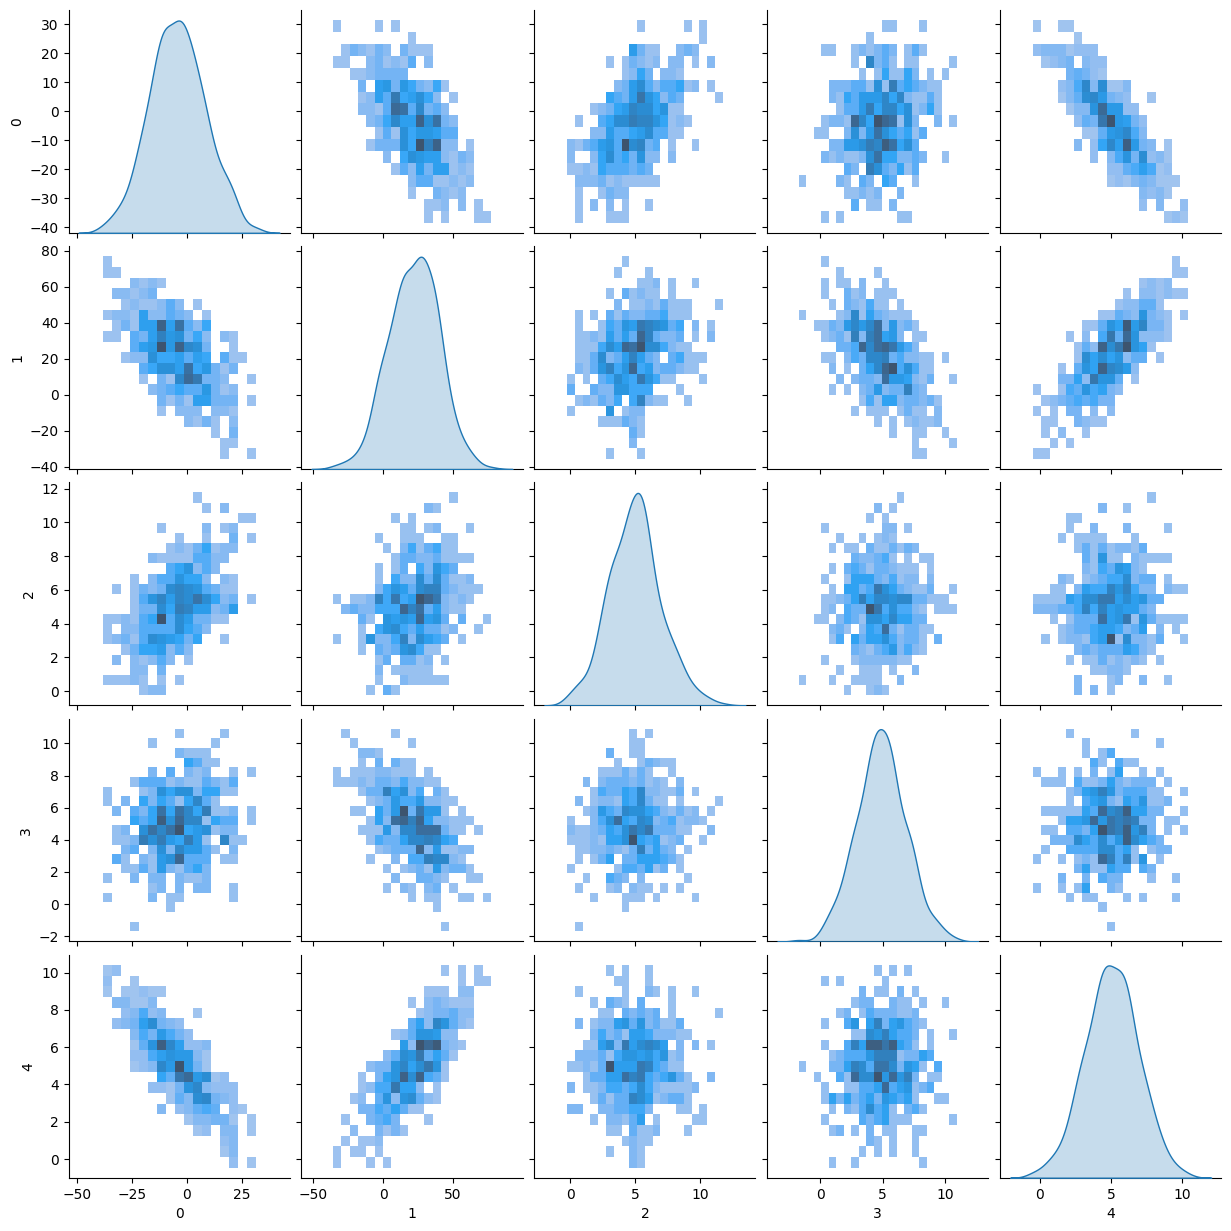

In [3]:
tmp=np.concatenate((y,x),axis=1); print(tmp.shape)
df=pd.DataFrame(tmp)
sns.pairplot(df, diag_kind='kde', kind="hist")  
plt.show()

## Sk-learn: Sanity check

* As with many models, we can do all our linear vector regression with a few lines of SkLearn code
  
* However, the point of the lab is to understand the process, and what is happening "under the hood"

In [4]:
import numpy as np
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x, y)
reg.score(x, y)

print(reg.coef_)
print(reg.intercept_)

[[ 3.4  1.2 -5.6]
 [ 2.4 -5.2  7.6]]
[ 1.1 -3. ]


If everything worked, this should match the values of our ground truth parametrization

Remember, typically we will not know the ground truth parametrization

$$ \mathbf w =\begin{pmatrix}
3.4 & 1.2 & -5.6\\
2.4 & -5.2 & 7.6\\
\end{pmatrix} \,\,\,\,\,\, \mathbf b =\begin{pmatrix}
1.1  \\
-3.0  \\
\end{pmatrix}
$$

# Part-2: Numerical training

In this case we will train the model numerically, similar to what we've done in the past.

## Define our model 

This case our model $\mathbf m$ is multi-variable linear vector regression.  

For a single input feature vector $\mathbf x^T=(x_0,x_1,x_2)$ the model is 

$$\mathbf y_{pred}=\begin{pmatrix} 
y_{0} \\ y_{1} \end{pmatrix}_{pred}=\mathbf m(\mathbf x | \mathbf w,\mathbf b)=\mathbf b+\mathbf w \mathbf x =  
\begin{pmatrix} b_{0} \\ b_{1}  
\end{pmatrix} + 
\begin{pmatrix}
w_{00} & w_{01} & w_{02}   \\
w_{10} & w_{11} & w_{12}  \\
\end{pmatrix} 
\begin{pmatrix} 
x_{0} \\ x_{1} \\ x_{2} 
\end{pmatrix}$$

Which, by design has the same form as the ground truth data generating function discussed above

It is common to introduce a constant feature, column of ones, so that the bias term $b$ can be absorbed into the $w$ matrix.

$$\mathbf x  \rightarrow \tilde{\mathbf x} =\begin{pmatrix}
1 \\ x_{0} \\ x_{1} \\ x_{2} \\
\end{pmatrix}
$$

In which case the model can be rewritten in a mathematically identical form

$$\mathbf y_{pred}=\mathbf m(\tilde{\mathbf x}| \tilde{\mathbf w})= \tilde{\mathbf w} \tilde{\mathbf x}=\begin{pmatrix}
b_{0} & w_{00} & w_{01} & w_{02} \\
b_{1} & w_{10} & w_{11} & w_{12} \\
\end{pmatrix}\begin{pmatrix} 1\\ x_0 \\ x_1 \\ x_2 \end{pmatrix}$$

Where the multiplication is matrix multiplication. 

Which obeys the shape requirements $[2 \times 4] [4 \times 1] \rightarrow [2 \times 1]$ 



## Batch implementation

The previous formula was for a single data-point $\mathbf x^T=(x_0,x_1,x_2)$.

The formula can also be rewritten so that it can be applied to the entire data set all at once.

Consider the following matrix of feature inputs

$$\tilde{\mathbf X} =\begin{pmatrix}
1 & x_{00} & x_{01} & x_{02} \\
1 & x_{10} & x_{11} & x_{12} \\
\vdots  & \vdots &\vdots \\
1 & x_{N0} & x_{N1} & x_{N2} \\
\end{pmatrix}$$

Model can be applied to the entire matrix as

$$\begin{pmatrix} 
y_{00} & y_{01} \dots & y_{0N} \\
y_{10} & y_{11} \dots & y_{1N}\\
\end{pmatrix}_{pred}= \tilde{\mathbf w} \tilde{\mathbf X}^T=\begin{pmatrix}
b_{0} & w_{00} & w_{01} & w_{02} \\
b_{1} & w_{10} & w_{11} & w_{12} \\
\end{pmatrix}
\begin{pmatrix}
1      & 1 &  \dots  & 1\\
x_{00} & x_{10} &\dots  & x_{N0}\\
x_{01} & x_{11} &\dots & x_{N1} \\
x_{02} & x_{12} &\dots & x_{N2} \\
\end{pmatrix}$$

Where the multiplication is matrix multiplication. 

Which obeys the shape requirements $[2 \times 4] [4 \times N] \rightarrow [2 \times N]$ 

**In Summary:** We can evaluate the entire model, for all inputs at once, with the formula above.

## Lab-1.2.1: Prepare the data

In [5]:
# INSERT CODE HERE TO ADD A COLUMN OF ONES TO THE INPUT FEATURE MATRIX 
x_inp = np.hstack((np.ones((len(x_train),1)), x_train))
print(x_inp.shape)

(500, 4)


**Split the data**

As usual let's split our data into training and validation.

Note: If you have already completed homework-1, then you can recycle some of that code here.

In [6]:
#INSERT CODE TO PARTITION THE DATA INTO AN 80-20 SPLIT
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_inp, y, test_size = .2)

In [7]:
# RE-PRINT THE SHAPES
print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)

(400, 4) (400, 2)
(100, 4) (100, 2)


## Lab-1.2.2 Set up the model

In [79]:
# INSERT CODE TO CONSTRUCT AN INITIAL GUESS FOR THE MATRIX 
# If you're using sci-py minimizer below, then this should be a long vector of the unwrapped matrix
# Think carefully about the correct shape, this can be inferred from the shapes of x_train and y_train
w0 = np.random.normal(0, 1, (y_train.shape[1], x_train.shape[1]))

In [80]:
# RUN THE FOLLOWING CODE
print("INITIAL GUESS: w_0 =\n",w0)
print("SHAPE:",w0.shape)

INITIAL GUESS: w_0 =
 [[ 1.4985349  -0.44285638 -0.12508637 -1.22815416]
 [ 0.95805612  0.83632352 -0.95384599 -0.38480872]]
SHAPE: (2, 4)


In [81]:
# INSERT CODE TO EVALUATE THE BATCH IMPLEMENTATION OF THE VECTOR REGRESSION MODEL 
# DISCUSSED ABOVE (don't over-think it, it is a two-line model)
# If you're input of the parameters is a vector, you will need to reshape it into a matrix
y_pred = np.matmul(w0, x_train.T)
y_pred.shape

(2, 400)

In [92]:
# INSERT CODE FOR THE LOSS FUNCTION (USE RMSE)
# NOTE YOU MAY NEED TO RESHAPE y_pred SO THAT IT IS THE SAME SHAPE AS y_train
def rmse(pred, train):
    return np.sqrt(np.mean((train - pred)**2))

def L(w_i):
    ## Vector of w's comes in as a flat array - must be reshpaed before matrix multiplication
    w_i = w_i.reshape(4,2)
    y_pred = np.matmul(x_train, w_i)
    error = rmse(y_pred, y_train)
    return error


## Lab-1.2.3: Train the model numerically

In [93]:
# INSERT CODE TO FIT THE MODEL USING NUMERIC OPTIMIZATION
#   YOU CAN USE THE SCI-PY MINIMIZER OR THE MINIMIZER YOU CODED FROM HW-1)
final = minimize(L, np.random.normal(0, 1, (x_train.shape[1]*y_train.shape[1])))
final.x.reshape(4,2).T

array([[ 1.10000055,  3.39999995,  1.19999997, -5.60000003],
       [-2.99999957,  2.39999995, -5.20000001,  7.59999998]])

If everything worked, this should match the values of our ground truth parametrization

Remember, typically we will not know the ground truth parametrization

$$ \mathbf w =\begin{pmatrix}
3.4 & 1.2 & -5.6\\
2.4 & -5.2 & 7.6\\
\end{pmatrix} \,\,\,\,\,\, \mathbf b =\begin{pmatrix}
1.1  \\
-3.0  \\
\end{pmatrix}
$$

In [95]:
# INSERT CODE TO PRINT THE RMSE FOR THE VALIDATION AND TRAINING SET
y_pred_train = np.matmul(x_train, final.x.reshape(4,2))
y_pred_val = np.matmul(x_val, final.x.reshape(4,2))
print("TRAINING LOSS (RMSE) :", rmse(y_pred_train, y_train))
print("VALIDATION LOSS (RMSE) :", rmse(y_pred_val, y_val))

TRAINING LOSS (RMSE) : 1.2961088539290924e-07
VALIDATION LOSS (RMSE) : 1.1321631874223668e-07


# Part-3: Analytic "training"

In the final section we will train the model using the analytical solution, derived with pen and paper in the HW, instead of numerical optimization.

## Lab-1.2.4: 

* In practice, we don't actually have to use numerical optimization to solve the vector regression problem
* Just as with scalar regression, we can use the formula we derived with "pen and paper" in HW-1
* Notice that the columns of Y are independent, since the various columns don't explicitly depend on each other.
* Therefore, the vector-regression is just repeated scalar regression (i.e. what we did in the homework)
* So you can simply apply the standard scalar regression formulae to each $y_i$ one at a time.
* Insert code below to write a for loop to iterate over the columns of $\mathbf y$ 
* For each column apply the scalar linear regression formula that you derived in HW-1
 $$\mathbf w = (\mathbf x^T \mathbf x)^{-1} \mathbf x^T y$$
* Recall that to use this formula you need to add a "constant feature", a column of ones, to the x_train matrix to account for the bias parameter 
  * `x_train[0,:]=[A,B,C]` $\rightarrow$ `x_train[0,:]=[0,A,B,C]`
  * `x_train[1,:]=[A,B,C]` $\rightarrow$ `x_train[1,:]=[0,A,B,C]`
  *  ... etc
*  Which we already did above
*  You also need to take the transpose `x.T`, the inverse `np.linalg.inv()`, and three matrix products `np.matmul`
*  Using the `y_train` and the modified `x_train`, your numbers should match Sk-Learn perfectly 
   *  (because this is the formula that Sk-Learn uses, NOT numerical optimization) 


In [97]:
w = np.matmul(np.matmul(np.linalg.inv(np.matmul(x_train.T, x_train)),x_train.T), y_train).T
print(w)

[[ 1.1  3.4  1.2 -5.6]
 [-3.   2.4 -5.2  7.6]]


If everything worked, this should match the values of our ground truth parametrization

Remember, typically we will not know the ground truth parametrization

$$ \mathbf w =\begin{pmatrix}
3.4 & 1.2 & -5.6\\
2.4 & -5.2 & 7.6\\
\end{pmatrix} \,\,\,\,\,\, \mathbf b =\begin{pmatrix}
1.1  \\
-3.0  \\
\end{pmatrix}
$$